In [2]:
import torch
import torch.nn as nn

import torchvision.datasets
import torchvision.transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
config = {'batch_size':16,'latent_dim':10,'learning_rate':0.00001,'epoch':30}

In [7]:
# 학습 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MNIST datasets을 다운로드
train_data = torchvision.datasets.MNIST('./data',train = True,download=True, transform = torchvision.transforms.ToTensor())

# DataLoader에 데이터셋 탑재
train_dataloader = DataLoader(train_data, batch_size = config['batch_size'],shuffle=True, drop_last=True)



In [11]:
# Encoder, Decoder 설계
# Encoder의 결과(mu, logvar)가 Loss Function에 사용되므로 따로 구성

class Encoder(nn.Module):
  def __init__(self, x_dim= 784,h1_dim=196, h2_dim=49, z_dim = config['latent_dim']):
    super(Encoder, self).__init__()

    # 1st hidden layer: 784 -> 196
    self.fc1 = nn.Sequential(
        nn.Linear(x_dim, h1_dim),
        nn.ReLU()
    )

    # 2nd hidden layer: 196 -> 49
    self.fc2 = nn.Sequential(
        nn.Linear(h1_dim,h2_dim),
        nn.ReLU()
    )

    # output layer : 49 -> 10
    self.mu = nn.Linear(h2_dim, z_dim)
    self.logvar = nn.Linear(h2_dim, z_dim)

  def reparameterization(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)

    mu = self.mu(x)
    logvar = self.logvar(x)

    z = self.reparameterization(mu, logvar)
    return z,mu,logvar

class Decoder(nn.Module):
  def __init__(self, x_dim = 784, h1_dim = 196, h2_dim = 49, z_dim = config['latent_dim']):
    super(Decoder, self).__init__()

    # 1st hidden layer : 10 -> 49
    self.fc1 = nn.Sequential(
        nn.Linear(z_dim, h2_dim),
        nn.ReLU()
    )

    # 2nd hidden layer : 49 -> 196
    self.fc2 = nn.Sequential(
        nn.Linear(h2_dim, h1_dim),
        nn.ReLU()
    )

    # output layer : 196 -> 784
    self.fc3 = nn.Linear(h1_dim, x_dim)

  # 0~1의 값을 도출하기 위해 Sigmoid를 추가
  def forward(self, z):
    z = self.fc1(z)
    z = self.fc2(z)
    z = self.fc3(z)
    pred = nn.Sigmoid()(z)
    return pred


In [12]:
# Encoder, Decoder를 생성하고 device에 올리기
encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 모델 파라미터, Learning rate를 기반으로 Optimizer 정의
parameters = list(encoder.parameters())+list(decoder.parameters())
optimizer = torch.optim.Adam(parameters, lr = config['learning_rate'])


In [13]:
# 이미지의 label은 사용되지 않는다

for epoch in tqdm(range(config['epoch'])):
  for i, (x,_) in enumerate(train_dataloader):
    # Forward
    input = x.view(config['batch_size'], -1).to(device)
    z, mu, logvar = encoder(input)
    output = decoder(z)

    # Reconstruction loss, Regularization loss 계산
    reconst_loss = nn.BCELoss(reduction='sum')(output,input)
    regular_loss = 0.5 * torch.sum(mu**2 +torch.exp(logvar)-logvar -1)

    # Backward
    loss = reconst_loss + regular_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f" Loss: {loss}")

  3%|▎         | 1/30 [00:16<08:12, 16.99s/it]

 Loss: 4016.05517578125


  7%|▋         | 2/30 [00:34<07:56, 17.03s/it]

 Loss: 3489.419677734375


 10%|█         | 3/30 [00:50<07:32, 16.77s/it]

 Loss: 3563.5263671875


 13%|█▎        | 4/30 [01:07<07:19, 16.90s/it]

 Loss: 2972.950439453125


 17%|█▋        | 5/30 [01:24<06:59, 16.78s/it]

 Loss: 3123.278564453125


 20%|██        | 6/30 [01:40<06:40, 16.68s/it]

 Loss: 3226.722900390625


 23%|██▎       | 7/30 [01:57<06:27, 16.84s/it]

 Loss: 2956.2890625


 27%|██▋       | 8/30 [02:14<06:08, 16.75s/it]

 Loss: 3043.1259765625


 30%|███       | 9/30 [02:31<05:56, 16.97s/it]

 Loss: 2990.10205078125


 33%|███▎      | 10/30 [02:48<05:36, 16.85s/it]

 Loss: 2629.0361328125


 37%|███▋      | 11/30 [03:05<05:20, 16.84s/it]

 Loss: 2605.35693359375


 40%|████      | 12/30 [03:22<05:04, 16.94s/it]

 Loss: 2724.303466796875


 43%|████▎     | 13/30 [03:39<04:47, 16.90s/it]

 Loss: 2669.046875


 47%|████▋     | 14/30 [03:58<04:42, 17.68s/it]

 Loss: 2576.9140625


 50%|█████     | 15/30 [04:18<04:33, 18.24s/it]

 Loss: 2458.47119140625


 53%|█████▎    | 16/30 [04:39<04:28, 19.20s/it]

 Loss: 2613.428466796875


 57%|█████▋    | 17/30 [04:59<04:11, 19.31s/it]

 Loss: 2391.224609375


 60%|██████    | 18/30 [05:15<03:42, 18.52s/it]

 Loss: 2623.355224609375


 63%|██████▎   | 19/30 [05:34<03:22, 18.45s/it]

 Loss: 2466.53955078125


 67%|██████▋   | 20/30 [05:54<03:09, 18.99s/it]

 Loss: 2288.7392578125


 70%|███████   | 21/30 [06:18<03:04, 20.54s/it]

 Loss: 2633.669677734375


 73%|███████▎  | 22/30 [06:39<02:44, 20.59s/it]

 Loss: 2550.629150390625


 77%|███████▋  | 23/30 [06:59<02:24, 20.60s/it]

 Loss: 2462.8193359375


 80%|████████  | 24/30 [07:19<02:01, 20.17s/it]

 Loss: 2381.42626953125


 83%|████████▎ | 25/30 [07:36<01:36, 19.35s/it]

 Loss: 2328.0146484375


 87%|████████▋ | 26/30 [07:53<01:14, 18.72s/it]

 Loss: 2304.31640625


 90%|█████████ | 27/30 [08:10<00:54, 18.20s/it]

 Loss: 2001.473388671875


 93%|█████████▎| 28/30 [08:27<00:35, 17.87s/it]

 Loss: 2060.501220703125


 97%|█████████▋| 29/30 [08:46<00:17, 17.96s/it]

 Loss: 2576.785400390625


100%|██████████| 30/30 [09:02<00:00, 18.09s/it]

 Loss: 2332.851806640625


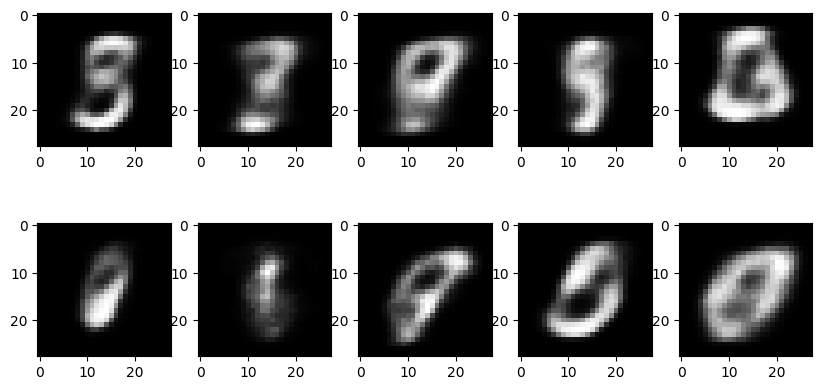

In [17]:
# N(0,1)에서 반복추출하여 latent vector z를 Sampling
# check_num_image : Inference 하고자 하는 이미지 수
check_num_image = 10
z = torch.randn(check_num_image, config['latent_dim']).to(device)
sampled_images = decoder(z).view(check_num_image,28,28)

# Inference 결과 시각화
fig = plt.figure(figsize = (10, (check_num_image//2)))
for idx, img in enumerate(sampled_images):
  ax = fig.add_subplot(2,check_num_image//2, idx+1)
  img = img.detach().cpu().numpy()
  ax.imshow(img, cmap= 'gray')